# Analyzing NYC High School Data

We can learn a few different things from these resources. For example:

- Only high school students take the SAT, so we'll want to focus on high schools.
- New York City is made up of five boroughs, which are essentially distinct regions.
- New York City schools fall within several different school districts, each of which can contain dozens of schools.
- Our datasets include several different types of schools. We'll need to clean them so that we can focus on high schools only.
- Each school in New York City has a unique code called a DBN or district borough number.
- Aggregating data by district allows us to use the district mapping data to plot district-by-district differences.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import re

## Reading in the Data

In [2]:
data_file = ['2010__AP.csv',
            'Class_Size.csv', 
            'Demographics.csv',
            'Directory.csv',
            'Graduation.csv',
            'SAT_Results.csv']

data = {}
for f in data_file:
    d = pd.read_csv('D:\\project_python\\7. Walkthrough\\{0}'.format(f))
    key_name = f.replace('.csv', '')
    data[key_name] = d

print(data)

{'2010__AP':         DBN                                         SchoolName  \
0    01M448                       UNIVERSITY NEIGHBORHOOD H.S.   
1    01M450                             EAST SIDE COMMUNITY HS   
2    01M515                                LOWER EASTSIDE PREP   
3    01M539                     NEW EXPLORATIONS SCI,TECH,MATH   
4    02M296              High School of Hospitality Management   
..      ...                                                ...   
253  31R605                         STATEN ISLAND TECHNICAL HS   
254  32K545                      EBC-HS FOR PUB SERVICE (BUSH)   
255  32K552                          Academy of Urban Planning   
256  32K554               All City Leadership Secondary School   
257  32K556  Bushwick Leaders High School for Academic Exce...   

     AP Test Takers   Total Exams Taken  Number of Exams with scores 3 4 or 5  
0               39.0               49.0                                  10.0  
1               19.0              

In [3]:
for k in data:
    print(data[k].head())
    print('--------')

      DBN                             SchoolName  AP Test Takers   \
0  01M448           UNIVERSITY NEIGHBORHOOD H.S.             39.0   
1  01M450                 EAST SIDE COMMUNITY HS             19.0   
2  01M515                    LOWER EASTSIDE PREP             24.0   
3  01M539         NEW EXPLORATIONS SCI,TECH,MATH            255.0   
4  02M296  High School of Hospitality Management              NaN   

   Total Exams Taken  Number of Exams with scores 3 4 or 5  
0               49.0                                  10.0  
1               21.0                                   NaN  
2               26.0                                  24.0  
3              377.0                                 191.0  
4                NaN                                   NaN  
--------
   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente   

## Reading in the Survey Data

In [4]:
all_survey = pd.read_csv('D:\\project_python\\7. Walkthrough\\gened_final.txt', delimiter='\t', encoding='windows-1252')
d75_survey = pd.read_csv('D:\\project_python\\7. Walkthrough\\d75_final.txt', delimiter='\t', encoding='windows-1252')

In [5]:
survey = pd.concat([all_survey, d75_survey])
print(survey.head())

      dbn    bn                      schoolname  d75 studentssurveyed  \
0  01M015  M015       P.S. 015 Roberto Clemente    0               No   
1  01M019  M019             P.S. 019 Asher Levy    0               No   
2  01M020  M020            P.S. 020 Anna Silver    0               No   
3  01M034  M034  P.S. 034 Franklin D. Roosevelt    0              Yes   
4  01M063  M063       P.S. 063 William McKinley    0               No   

   highschool                  schooltype  rr_s  rr_t  rr_p  ...  s_q14_2  \
0         0.0           Elementary School   NaN    88    60  ...      NaN   
1         0.0           Elementary School   NaN   100    60  ...      NaN   
2         0.0           Elementary School   NaN    88    73  ...      NaN   
3         0.0  Elementary / Middle School  89.0    73    50  ...      NaN   
4         0.0           Elementary School   NaN   100    60  ...      NaN   

   s_q14_3  s_q14_4  s_q14_5  s_q14_6  s_q14_7  s_q14_8  s_q14_9  s_q14_10  \
0      NaN      NaN 

In [6]:
## Cleaning Up the Surveys
survey = survey.rename(columns={'dbn': 'DBN'})
survey = survey[["DBN", "rr_s", "rr_t", "rr_p", "N_s", "N_t",
                 "N_p", "saf_p_11", "com_p_11", "eng_p_11",
                 "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11",
                 "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11",
                 "aca_s_11", "saf_tot_11", "com_tot_11",
                 "eng_tot_11", "aca_tot_11"]]
data['survey'] = survey
print(data['survey'])

       DBN  rr_s  rr_t  rr_p    N_s   N_t    N_p  saf_p_11  com_p_11  \
0   01M015   NaN    88    60    NaN  22.0   90.0       8.5       7.6   
1   01M019   NaN   100    60    NaN  34.0  161.0       8.4       7.6   
2   01M020   NaN    88    73    NaN  42.0  367.0       8.9       8.3   
3   01M034  89.0    73    50  145.0  29.0  151.0       8.8       8.2   
4   01M063   NaN   100    60    NaN  23.0   90.0       8.7       7.9   
..     ...   ...   ...   ...    ...   ...    ...       ...       ...   
51  75X352  90.0    58    48   38.0  46.0  160.0       8.9       8.3   
52  75X721  84.0    90    48  237.0  82.0  239.0       8.6       7.6   
53  75X723  77.0    74    20  103.0  69.0   74.0       8.4       7.8   
54  75X754  63.0    93    22  336.0  82.0  124.0       8.3       7.5   
55  75X811  38.0    63    19   44.0  71.0  119.0       8.5       7.8   

    eng_p_11  ...  eng_t_11  aca_t_11  saf_s_11  com_s_11  eng_s_11  aca_s_11  \
0        7.5  ...       7.6       7.9       NaN       

## Inserting DBN Fields

When we explored all of the datasets, we noticed that some of them, like `Class_Size`, don't have a `DBN` column.

In [7]:
data['Class_Size'].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN




From looking at these rows, we can tell that the `DBN` in the `SAT_Results` data is just a combination of the `CSD` and `SCHOOL CODE` columns in the `Class_Size` data. The main difference is that the `DBN` is padded, so that the `CSD` portion of it always consists of two digits. That means we'll need to add a leading 0 to the `CSD` if the `CSD` is less than two digits long. Here's a diagram illustrating what we need to do

In [8]:
data['Class_Size']['padded_csd'] = data['Class_Size']['CSD'].apply(lambda x: str(x).zfill(2) if len(str(x))<2 else str(x))
data['Class_Size']['DBN'] = data['Class_Size']['padded_csd'] + data['Class_Size']['SCHOOL CODE'].astype('str')

data['Class_Size'].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN,01,01M015
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN,01,01M015
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN,01,01M015


## Combining the SAT Scores

Before we can generate this column, we'll need to convert the `SAT Math Avg. Score`, `SAT Critical Reading Avg. Score`, and `SAT Writing Avg. Score` columns in the `sat_results` dataset from the object (string) data type to a numeric data type.

In [9]:
data['SAT_Results'].head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


In [10]:
scores = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']

for s in scores:
    data['SAT_Results'][s] = pd.to_numeric(data['SAT_Results'][s], errors='coerce')
    
data['SAT_Results']['sat_score'] = data['SAT_Results']['SAT Critical Reading Avg. Score'] + data['SAT_Results']['SAT Math Avg. Score'] + data['SAT_Results']['SAT Writing Avg. Score']
data['SAT_Results'].head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0
3,01M458,FORSYTH SATELLITE ACADEMY,7,414.0,401.0,359.0,1174.0
4,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0


## Parsing Geographic Coordinates for Schools

Next, we'll want to parse the latitude and longitude coordinates for each school. This enables us to map the schools and uncover any geographic patterns in the data. The coordinates are currently in the text field `Location 1` in the `hs_directory` dataset.

In [11]:
data['Directory']['Location 1'].head()

0    8 21 Bay 25 Street\nFar Rockaway, NY 11691\n(4...
1    2630 Benson Avenue\nBrooklyn, NY 11214\n(40.59...
2    1014 Lafayette Avenue\nBrooklyn, NY 11221\n(40...
3    1980 Lafayette Avenue\nBronx, NY 10473\n(40.82...
4    100 Amsterdam Avenue\nNew York, NY 10023\n(40....
Name: Location 1, dtype: object

In [12]:
def lat(string):
    coords = re.findall('\(.+\)', string)
    for c in coords:
        lat = c.split(',')[0].replace('(', '')
        return lat
data['Directory']['lat'] = pd.to_numeric(data['Directory']['Location 1'].apply(lat), errors='coerce')

def lon(string):
    coords = re.findall('\(.+\)', string)
    for c in coords:
        lon = c.split(',')[1].replace(')', '')
        return lon
data['Directory']['lon'] = pd.to_numeric(data['Directory']['Location 1'].apply(lon), errors='coerce')

In [13]:
data['Directory'] = data['Directory'].rename(columns={'dbn': 'DBN'})

In [14]:
data['Directory'].head()

,DBN,school_name,borough,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,...,priority10,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA,lat,lon
0,27Q260,Frederick Douglass Academy VI High School,Queens,Q465,718-471-2154,718-471-2890,9.0,12,NaN,NaN,...,NaN,"8 21 Bay 25 Street\nFar Rockaway, NY 11691\n(4...",14.0,31.0,100802.0,4300730.0,4.157360e+09,Far Rockaway-Bayswater ...,40.601989,-73.762834
1,21K559,Life Academy High School for Film and Music,Brooklyn,K400,718-333-7750,718-333-7775,9.0,12,NaN,NaN,...,NaN,"2630 Benson Avenue\nBrooklyn, NY 11214\n(40.59...",13.0,47.0,306.0,3186454.0,3.068830e+09,Gravesend ...,40.593594,-73.984729
2,16K393,Frederick Douglass Academy IV Secondary School,Brooklyn,K026,718-574-2820,718-574-2821,9.0,12,NaN,NaN,...,NaN,"1014 Lafayette Avenue\nBrooklyn, NY 11221\n(40...",3.0,36.0,291.0,3393805.0,3.016160e+09,Stuyvesant Heights ...,40.692134,-73.931503
3,08X305,Pablo Neruda Academy,Bronx,X450,718-824-1682,718-824-1663,9.0,12,NaN,NaN,...,NaN,"1980 Lafayette Avenue\nBronx, NY 10473\n(40.82...",9.0,18.0,16.0,2022205.0,2.036040e+09,Soundview-Castle Hill-Clason Point-Harding Par...,40.822304,-73.855961
4,03M485,Fiorello H. LaGuardia High School of Music & A...,Manhattan,M485,212-496-0700,212-724-5748,9.0,12,NaN,NaN,...,NaN,"100 Amsterdam Avenue\nNew York, NY 10023\n(40....",7.0,6.0,151.0,1030341.0,1.011560e+09,Lincoln Square ...,40.773671,-73.985269


## Condensing the Class Size Dataset

In [15]:
class_size = data['Class_Size']
print(class_size)

       CSD BOROUGH SCHOOL CODE                     SCHOOL NAME GRADE   \
0        1       M        M015       P.S. 015 Roberto Clemente     0K   
1        1       M        M015       P.S. 015 Roberto Clemente     0K   
2        1       M        M015       P.S. 015 Roberto Clemente     01   
3        1       M        M015       P.S. 015 Roberto Clemente     01   
4        1       M        M015       P.S. 015 Roberto Clemente     02   
...    ...     ...         ...                             ...    ...   
27606   32       K        K564  Bushwick Community High School  09-12   
27607   32       K        K564  Bushwick Community High School  09-12   
27608   32       K        K564  Bushwick Community High School  09-12   
27609   32       K        K564  Bushwick Community High School  09-12   
27610   32       K        K564  Bushwick Community High School    NaN   

      PROGRAM TYPE CORE SUBJECT (MS CORE and 9-12 ONLY)  \
0           GEN ED                                    -   
1    

In [16]:
class_size['GRADE '].unique()

array(['0K', '01', '02', '03', '04', '05', '0K-09', nan, '06', '07', '08',
       'MS Core', '09-12', '09'], dtype=object)

Since we're dealing with high schools, we're only concerned with grades 9 through 12. That means we only want to pick rows where the value in the `GRADE` column is "09-12".

In [17]:
class_size['PROGRAM TYPE'].value_counts()

PROGRAM TYPE
GEN ED     14545
CTT         7460
SPEC ED     3653
G&T          469
Name: count, dtype: int64

Each school can have multiple program types. Since "GEN ED" is the largest category by far, let's only select rows where `PROGRAM TYPE` is "GEN ED".

In [18]:
class_size = class_size[(class_size['GRADE '] == '09-12') & (class_size['PROGRAM TYPE'] == 'GEN ED')]
data['Class_Size'] = class_size
print(class_size.head())

     CSD BOROUGH SCHOOL CODE                                    SCHOOL NAME  \
225    1       M        M292  Henry Street School for International Studies   
226    1       M        M292  Henry Street School for International Studies   
227    1       M        M292  Henry Street School for International Studies   
228    1       M        M292  Henry Street School for International Studies   
229    1       M        M292  Henry Street School for International Studies   

    GRADE  PROGRAM TYPE CORE SUBJECT (MS CORE and 9-12 ONLY)  \
225  09-12       GEN ED                              ENGLISH   
226  09-12       GEN ED                              ENGLISH   
227  09-12       GEN ED                              ENGLISH   
228  09-12       GEN ED                              ENGLISH   
229  09-12       GEN ED                                 MATH   

    CORE COURSE (MS CORE and 9-12 ONLY) SERVICE CATEGORY(K-9* ONLY)  \
225                           English 9                           -  

## Computing Average Class Sizes

`CORE COURSE (MS CORE and 9-12 ONLY)` and `CORE SUBJECT (MS CORE and 9-12 ONLY)` seem to pertain to different kinds of classes. For example, here are the unique values for `CORE SUBJECT (MS CORE and 9-12 ONLY)`:

In [19]:
class_size['CORE SUBJECT (MS CORE and 9-12 ONLY)'].unique()

array(['ENGLISH', 'MATH', 'SCIENCE', 'SOCIAL STUDIES'], dtype=object)

Ee can do is take the average across all of the classes a school offers. This gives us unique DBN values, while also incorporating as much data as possible into the average.

In [20]:
class_size = class_size[['DBN', 'CSD', 'NUMBER OF STUDENTS / SEATS FILLED',
                         'NUMBER OF SECTIONS', 'AVERAGE CLASS SIZE', 'SIZE OF SMALLEST CLASS', 
                         'SIZE OF LARGEST CLASS', 'SCHOOLWIDE PUPIL-TEACHER RATIO']].groupby('DBN').agg(np.mean)
class_size.reset_index(inplace=True)
data['Class_Size'] = class_size
print(data['Class_Size'])

        DBN   CSD  NUMBER OF STUDENTS / SEATS FILLED  NUMBER OF SECTIONS  \
0    01M292   1.0                          88.000000            4.000000   
1    01M332   1.0                          46.000000            2.000000   
2    01M378   1.0                          33.000000            1.000000   
3    01M448   1.0                         105.687500            4.750000   
4    01M450   1.0                          57.600000            2.733333   
..      ...   ...                                ...                 ...   
578  32K549  32.0                          71.066667            3.266667   
579  32K552  32.0                         102.375000            4.312500   
580  32K554  32.0                          66.937500            3.812500   
581  32K556  32.0                         132.333333            5.400000   
582  32K564  32.0                         136.142857            5.428571   

     AVERAGE CLASS SIZE  SIZE OF SMALLEST CLASS  SIZE OF LARGEST CLASS  \
0            

## Condensing the Demographics Data Set

In [21]:
data['Demographics'].head()

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
0,01M015,P.S. 015 ROBERTO CLEMENTE,20052006,89.4,NaN,281,15,36,40,33,...,74,26.3,189,67.3,5,1.8,158.0,56.2,123.0,43.8
1,01M015,P.S. 015 ROBERTO CLEMENTE,20062007,89.4,NaN,243,15,29,39,38,...,68,28.0,153,63.0,4,1.6,140.0,57.6,103.0,42.4
2,01M015,P.S. 015 ROBERTO CLEMENTE,20072008,89.4,NaN,261,18,43,39,36,...,77,29.5,157,60.2,7,2.7,143.0,54.8,118.0,45.2
3,01M015,P.S. 015 ROBERTO CLEMENTE,20082009,89.4,NaN,252,17,37,44,32,...,75,29.8,149,59.1,7,2.8,149.0,59.1,103.0,40.9
4,01M015,P.S. 015 ROBERTO CLEMENTE,20092010,,96.5,208,16,40,28,32,...,67,32.2,118,56.7,6,2.9,124.0,59.6,84.0,40.4


In this case, the only column that prevents a given `DBN` from being unique is `schoolyear`. We only want to select rows where `schoolyear` is "20112012". This will give us the most recent year of data, and also match our SAT results data

In [22]:
demo = data['Demographics']
demo = demo[demo['schoolyear'] == 20112012]
data['Demographics'] = demo
print(demo.head())

       DBN                                              Name  schoolyear  \
6   01M015  P.S. 015 ROBERTO CLEMENTE                           20112012   
13  01M019  P.S. 019 ASHER LEVY                                 20112012   
20  01M020  PS 020 ANNA SILVER                                  20112012   
27  01M034  PS 034 FRANKLIN D ROOSEVELT                         20112012   
35  01M063  PS 063 WILLIAM MCKINLEY                             20112012   

   fl_percent  frl_percent  total_enrollment prek    k grade1 grade2  ...  \
6         NaN         89.4               189   13   31     35     28  ...   
13        NaN         61.5               328   32   46     52     54  ...   
20        NaN         92.5               626   52  102    121     87  ...   
27        NaN         99.7               401   14   34     38     36  ...   
35        NaN         78.9               176   18   20     30     21  ...   

   black_num black_per hispanic_num hispanic_per white_num white_per male_num  \

## Condensing the Graduation Data Set

In [23]:
data['Graduation'].head()

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
0,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2003,5,s,NaN,s,NaN,NaN,...,s,NaN,NaN,s,NaN,NaN,s,NaN,s,NaN
1,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2004,55,37,67.3,17,30.9,45.9,...,17,30.9,45.9,20,36.4,54.1,15,27.3,3,5.5
2,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2005,64,43,67.2,27,42.2,62.8,...,27,42.2,62.8,16,25.0,37.2,9,14.1,9,14.1
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1,36,46.2,83.7,...,36,46.2,83.7,7,9.0,16.3,16,20.5,11,14.1
4,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006 Aug,78,44,56.4,37,47.4,84.1,...,37,47.4,84.1,7,9.0,15.9,15,19.2,11,14.1


In [24]:
data['Graduation']['Cohort'].value_counts()

Cohort
2006 Aug    4131
2006        4130
2005        3963
2004        3708
2003        3432
2002        3095
2001        2637
Name: count, dtype: int64

In [25]:
data['Graduation']['Demographic'].value_counts()

Demographic
Total Cohort                   2493
English Proficient Students    2471
Special Education Students     2471
General Education Students     2471
Male                           2412
Black                          2403
Female                         2397
Hispanic                       2385
English Language Learners      2036
Asian                          1780
White                          1777
Name: count, dtype: int64

The Demographic and Cohort columns are what prevent DBN from being unique in the graduation data. A Cohort appears to refer to the year the data represents, and the Demographic appears to refer to a specific demographic group. In this case, we want to pick data from the most recent Cohort available, which is "2006". We also want data from the full cohort, so we'll only pick rows where Demographic is Total Cohort.

In [26]:
data['Graduation'] = data['Graduation'][(data['Graduation']['Demographic'] == 'Total Cohort') & (data['Graduation']['Cohort'] == '2006')]
data['Graduation'].head()

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1,36,46.2,83.7,...,36,46.2,83.7,7,9.0,16.3,16,20.5,11,14.1
10,Total Cohort,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2006,124,53,42.7,42,33.9,79.2,...,34,27.4,64.2,11,8.9,20.8,46,37.1,20,16.1
17,Total Cohort,01M450,EAST SIDE COMMUNITY SCHOOL,2006,90,70,77.8,67,74.4,95.7,...,67,74.4,95.7,3,3.3,4.3,15,16.7,5,5.6
24,Total Cohort,01M509,MARTA VALLE HIGH SCHOOL,2006,84,47,56.0,40,47.6,85.1,...,23,27.4,48.9,7,8.3,14.9,25,29.8,5,6.0
31,Total Cohort,01M515,LOWER EAST SIDE PREPARATORY HIGH SCHO,2006,193,105,54.4,91,47.2,86.7,...,22,11.4,21.0,14,7.3,13.3,53,27.5,35,18.1


## Converting AP Test Scores

In [27]:
data['2010__AP'].head()

,DBN,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5
0,01M448,UNIVERSITY NEIGHBORHOOD H.S.,39.0,49.0,10.0
1,01M450,EAST SIDE COMMUNITY HS,19.0,21.0,NaN
2,01M515,LOWER EASTSIDE PREP,24.0,26.0,24.0
3,01M539,"NEW EXPLORATIONS SCI,TECH,MATH",255.0,377.0,191.0
4,02M296,High School of Hospitality Management,NaN,NaN,NaN


we'll need to convert the AP exam scores in the `2010_AP` data set to numeric values first.

In [28]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']
for i in cols:
    print(data['2010__AP'][i].dtype)

float64
float64
float64


## We're ready to combine all of the datasets.

We'll merge two datasets at a time. For example, we'll merge `sat_results` and `hs_directory`, then merge the result with `ap_2010`, then merge the result of that with `class_size`. We'll continue combining datasets in this way until we've merged all of them. Afterwards, we'll have roughly the same number of rows, but each row has columns from all of the datasets.

Some datasets have DBN values that are almost identical to those in `sat_results`. Those datasets also have information we need to keep. Most of our analysis would be impossible if a significant number of rows was missing from `demographics`, for example. Therefore, we'll do an **inner join** to avoid missing data in these columns.

Both the ap_2010 and the graduation datasets have many missing DBN values, so we'll use a left join when we merge the sat_results data set with them. Since we're using a **left join**, our final dataframe will have all of the same "DBN" values as the original `sat_results` dataframe.

In [29]:
combined = data['SAT_Results']
combined = pd.merge(combined, data['2010__AP'], 'left', 'DBN')
combined = pd.merge(combined, data['Graduation'], 'left', 'DBN')
combined.shape

(479, 33)

Now that we've performed the left joins, we still have to merge class_size, demographics, survey, and hs_directory into combined. Since these files contain information that's more valuable to our analysis and also have fewer missing DBN values, we'll use the **inner join** type.

In [30]:
df = ['Class_Size', 'Demographics', 'survey', 'Directory']
for i in df:
    combined = pd.merge(combined, data[i], on='DBN')
combined.shape

(363, 164)

## Filling in Missing Values

We can fill in missing data in Pandas using the fillna method. This method will replace any missing values in a Dataframe with values that we specify. We can compute the means of every column using the mean method. If we pass the results of the mean method into the fillna method, Pandas will fill in the missing values in each column with the mean of that column.

In [31]:
cols = [col for col in combined.columns if combined[col].dtype != object]
combined = combined.fillna(combined[cols].mean())
combined = combined.fillna(0)
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority10,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA,lat,lon
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",3.0,1.0,201.0,1003223.0,1.002690e+09,Lower East Side ...,40.713764,-73.985260
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",3.0,1.0,202.0,1003214.0,1.002590e+09,Lower East Side ...,40.712332,-73.984797
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",3.0,2.0,34.0,1005974.0,1.004390e+09,East Village ...,40.729783,-73.983041
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,0,129.028846,197.038462,...,0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",3.0,1.0,3001.0,1004323.0,1.003540e+09,Chinatown ...,40.720569,-73.985673
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",3.0,2.0,2201.0,1004070.0,1.003350e+09,Lower East Side ...,40.718725,-73.979426


## Adding a School District Column

We've finished cleaning and combining our data! We now have a clean dataset on which we can base our analysis. One type of analysis that we might want to do is mapping out statistics on a school district level. In order to help us do this, it will be useful to add a column that specifies the school district to the dataset.

The school district is just the first two characters of the DBN. We can apply a function over the DBN column of combined that pulls out the first two letters.

In [32]:
def get_first_two_str(string):
    return string[0:2]
c_copy = combined.copy()
c_copy['school_dist'] = c_copy['DBN'].apply(get_first_two_str)
combined = pd.concat([combined, c_copy['school_dist']], axis=1)
combined['school_dist'].value_counts()

school_dist
02    48
10    22
09    20
11    15
17    14
14    14
24    13
13    13
07    13
12    12
03    12
19    12
08    11
28    11
18    11
21    11
06    10
27    10
31    10
15     9
30     9
25     8
29     8
05     7
04     7
01     6
32     6
26     5
20     5
22     4
16     4
23     3
Name: count, dtype: int64

## Finding Correlations

Correlations tell us how closely related two columns are. We'll be using the r value, also called Pearson's correlation coefficient, which measures how closely two sequences of numbers are correlated.

In [33]:
cols = [col for col in combined.columns if combined[col].dtype != object]
correlations = combined[cols].corr()
correlations['sat_score']

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
Census Tract                       0.048737
BIN                                0.052232
BBL                                0.044427
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 85, dtype: float64

## Plotting Survey Correlations

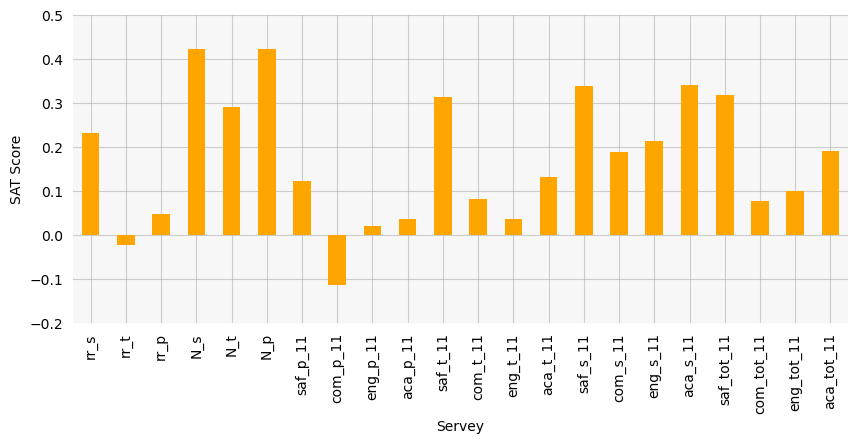

In [34]:
correlations['sat_score'][survey.columns[1:]].plot.bar(figsize=(10,4), color = 'orange', zorder=2)
plt.grid(alpha=0.6, zorder=1)
for i in ['left', 'bottom', 'top', 'right']:
    plt.gca().spines[i].set_visible(False) 

plt.tick_params(bottom=False, left=False)
plt.ylim(-0.2, 0.5)
plt.gca().set_facecolor('#f7f7f7')
plt.xlabel('Servey')
plt.ylabel('SAT Score')
plt.show()

There are high correlations between N_s, N_t, N_p and sat_score. Since these columns are correlated with total_enrollment, it makes sense that they would be high.

It is more interesting that rr_s, the student response rate, or the percentage of students that completed the survey, correlates with sat_score. This might make sense because students who are more likely to fill out surveys may be more likely to also be doing well academically.

How students and teachers percieved safety (saf_t_11 and saf_s_11) correlate with sat_score. This make sense, as it's hard to teach or learn in an unsafe environment.

The last interesting correlation is the aca_s_11, which indicates how the student perceives academic standards, correlates with sat_score, but this is not true for aca_t_11, how teachers perceive academic standards, or aca_p_11, how parents perceive academic standards.

## Plotting Enrollment

We can also make some other observations:

Unsurprisingly, SAT Critical Reading Avg. Score, SAT Math Avg. Score, SAT Writing Avg. Score, and sat_score are strongly correlated with sat_score.

We can also make some other observations:
- total_enrollment correlates strongly positively with sat_score, which is surprising, because you'd think smaller schools, which focused more on the student, would have higher scores. However, it looks like the opposite -- bigger schools tend to do better on the SAT.
- Other columns that are proxies for enrollment, like total_students, N_s, N_p, N_t, AP Test Takers, Total Exams Taken, and NUMBER OF SECTIONS correlate as well.
- The percentage of females at a school (female_per), and the number of females (female_num) correlate positively with SAT score, whereas the percentage of males (male_per), and the number of males (male_num) correlate negatively. This potentially indicates than women do better on the SAT than men.
- How highly teachers and students rated safety at the school (saf_t_11, and saf_s_11) correlates with sat_score.
- How highly students rated academic standards (aca_s_11) correlates with sat_score, but this does not hold for teachers and parents (aca_p_11 and aca_t_11).
- There is a significant racial inequality in SAT scores (white_per, asian_per, black_per, hispanic_per).
- The percentage of English language learners at the school (ell_percent, frl_percent) correlates strongly negatively with SAT scores.

Since enrollment seems to have such a strong correlation, let's make a scatterplot of total_enrollment vs sat_score. Each point in the scatterplot will represent a high school, so we'll be able to see if there are any interesting patterns.


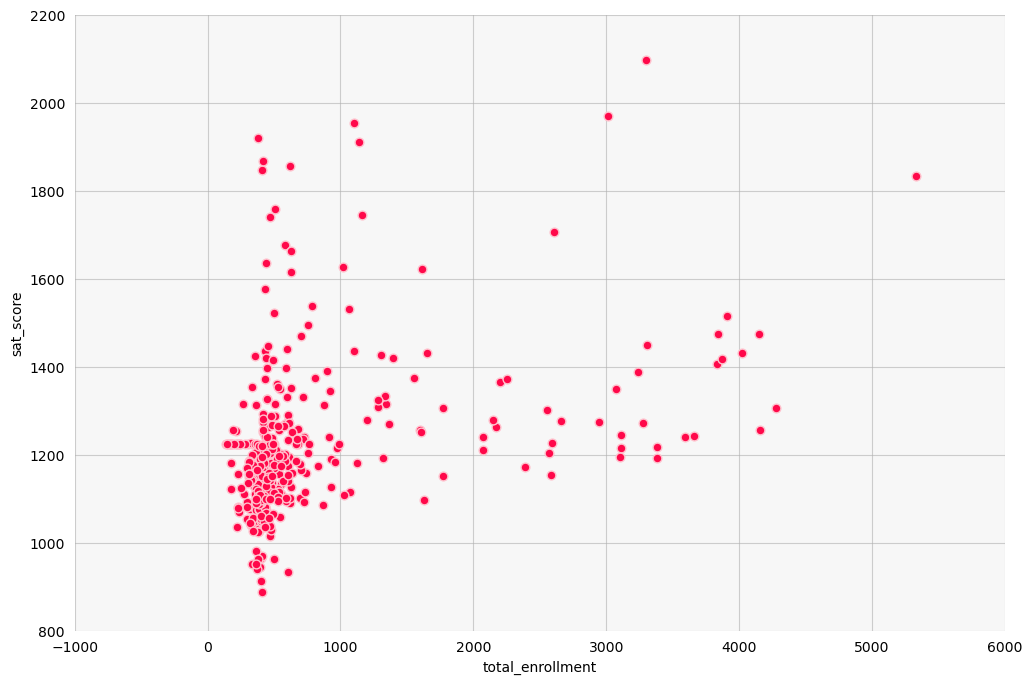

In [35]:
combined.plot.scatter('total_enrollment', 'sat_score', color='#ff084a',s=40,  figsize=(12,8), zorder=2, edgecolors='#ffc2cd')
plt.grid(alpha=0.6, zorder=1)
plt.xlim(-1000, 6000)
plt.ylim(800, 2200)
for i in ['right', 'left', 'bottom', 'top']:
    plt.gca().spines[i].set_visible(False) 
plt.tick_params(bottom=False, left=False)
plt.gca().set_facecolor('#f7f7f7')
plt.show()

## Exploring Schools With Low SAT Scores And Enrollment
From looking at the plot we just generated, it doesn't appear that there's an extremely strong correlation between sat_score and total_enrollment. If there was a very strong correlation, we'd expect all the points to be arranged in a line. Instead, there's a large cluster of schools, then a few schools going off in 3 different directions.

However, there is an interesting cluster of points at the bottom left where total_enrollment and sat_score are both low. This cluster may be what is causing our r-value to be so high. It's worth extracting the names of the schools in this cluster, so we can research them more.

In [36]:
low_enrollment = combined[(combined['total_enrollment']<1000) & (combined['sat_score']<1000)]
low_enrollment[['School Name', 'ell_percent']]

,School Name,ell_percent
91,INTERNATIONAL COMMUNITY HIGH SCHOOL,90.1
125,0,86.6
126,BRONX INTERNATIONAL HIGH SCHOOL,87.1
139,KINGSBRIDGE INTERNATIONAL HIGH SCHOOL,88.7
141,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,79.9
176,0,92.9
179,HIGH SCHOOL OF WORLD CULTURES,86.4
188,BROOKLYN INTERNATIONAL HIGH SCHOOL,83.1
225,INTERNATIONAL HIGH SCHOOL AT PROSPECT,91.0
237,IT TAKES A VILLAGE ACADEMY,30.4


From our research in the last screen, we found that most of the high schools with **low total enrollment** and **low SAT scores** are actually schools with a high percentage of English language learners enrolled. This indicates that it's actually `ell_percent` that correlates strongly with `sat_score` instead of `total_enrollment`. To explore this relationship more, let's plot out `ell_percent` vs `sat_score`.

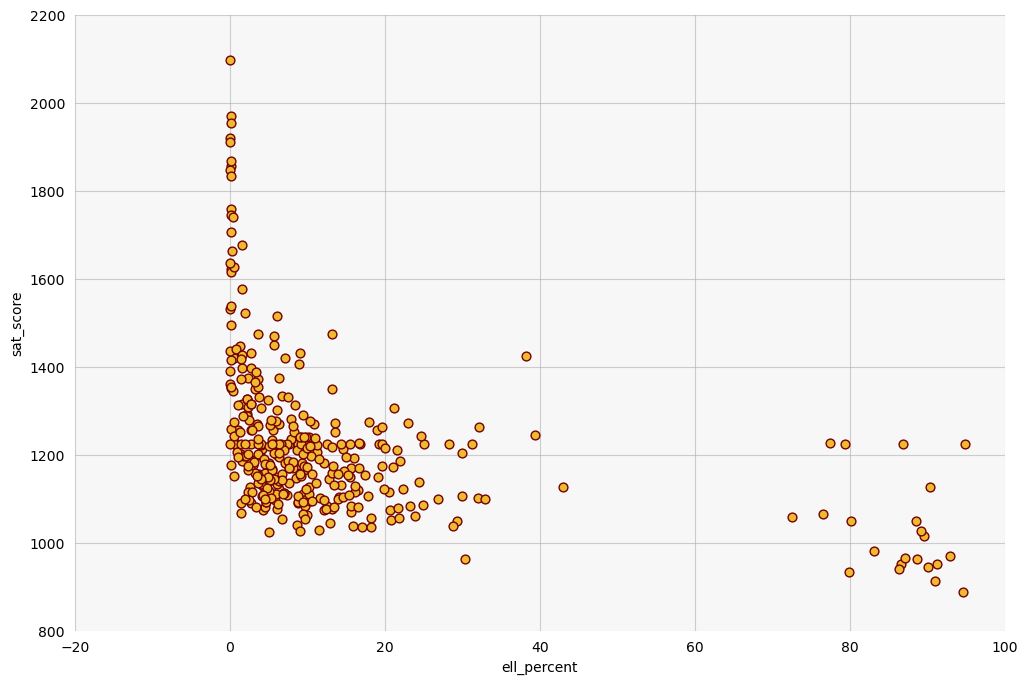

In [37]:
combined.plot.scatter('ell_percent', 'sat_score', color='#eeba30',s=40,  figsize=(12,8), zorder=2, edgecolors='#740001')
plt.grid(alpha=0.6, zorder=1)
plt.xlim(-20, 100)
plt.ylim(800, 2200)
for i in ['right', 'left', 'bottom', 'top']:
    plt.gca().spines[i].set_visible(False) 
plt.tick_params(bottom=False, left=False)
plt.gca().set_facecolor('#f7f7f7')
plt.show()

## Calculating District-Level Statistics

One way to make very granular statistics easier to read is to aggregate them. In this case, we aggregate by district, which enables us to understand how ell_percent varies district-by-district instead of the unintelligibly granular school-by-school variation.

In [38]:
cols = [col for col in combined.columns if combined[col].dtype != object or col == 'school_dist']
districts = combined[cols].groupby('school_dist').agg(np.mean)
districts.reset_index(inplace=True)
districts[['school_dist', 'ell_percent', 'sat_score']]

,school_dist,ell_percent,sat_score
0,01,10.000000,1354.500000
1,02,13.006250,1295.638184
2,03,9.025000,1293.443035
3,04,4.557143,1224.142857
4,05,4.157143,1285.062687
5,06,30.040000,1164.643881
6,07,16.661538,1128.846154
7,08,15.790909,1159.665129
8,09,19.945000,1131.971940
9,10,18.177273,1222.227273


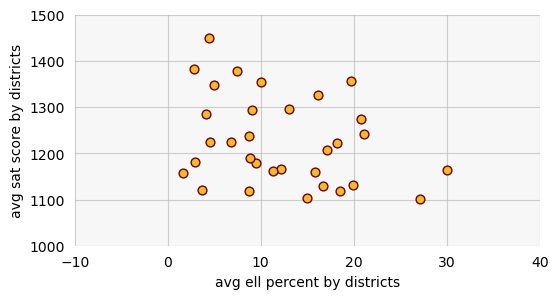

In [39]:
districts.plot.scatter('ell_percent', 'sat_score', color='#eeba30',s=40,  figsize=(6,3), zorder=2, edgecolors='#740001')
plt.grid(alpha=0.6, zorder=1)
plt.xlim(-10, 40)
plt.ylim(1000, 1500)
for i in ['right', 'left', 'bottom', 'top']:
    plt.gca().spines[i].set_visible(False) 
plt.tick_params(bottom=False, left=False)
plt.gca().set_facecolor('#f7f7f7')
plt.xlabel('avg ell percent by districts')
plt.ylabel('avg sat score by districts')
plt.show()

## Mapping The Schools
It looks like ell_percent correlates with sat_score more strongly, because the scatterplot is more linear. However, there's still the cluster with very high ell_percent and low sat_score, which is the same group of international high schools that we investigated earlier.

In order to explore this relationship, we'll want to map out ell_percent by school district, so we can more easily see which parts of the city have a lot of English language learners.

In order to do this, we'll need to be able to create maps. We extracted the coordinates of all the schools earlier, and stored them in the lat and lon columns. This will enable us to plot all of the schools onto a map of the US, centered on New York City.

## Safety And SAT Scores
We'll investigate safety scores.

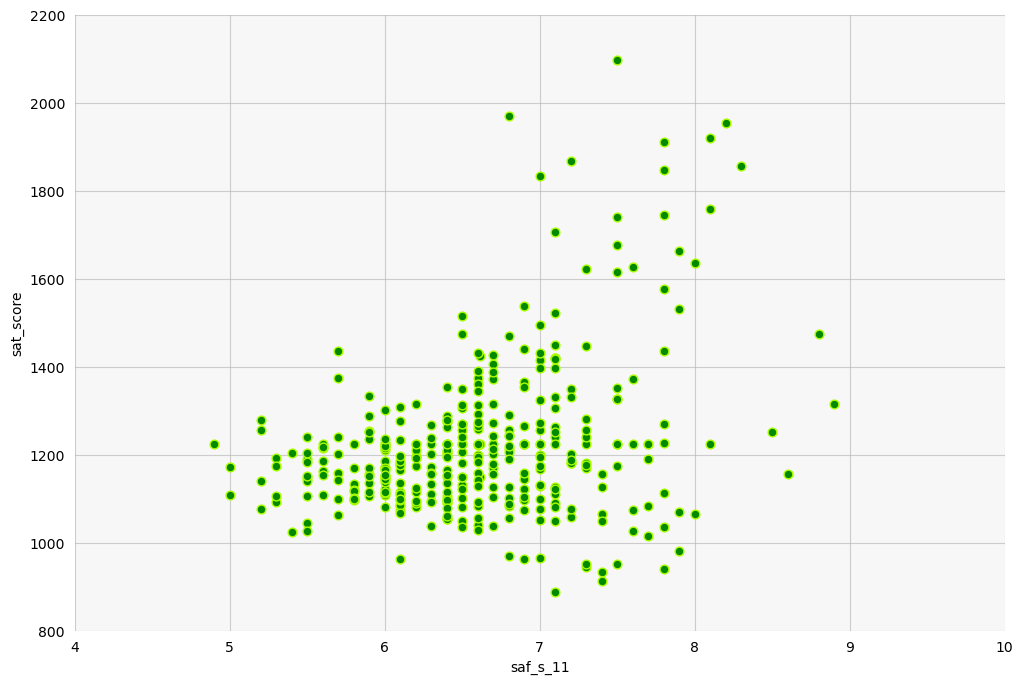

In [40]:
combined.plot.scatter('saf_s_11', 'sat_score', color='#028900',s=40,  figsize=(12, 8), zorder=2, edgecolors='#adff00')
plt.grid(alpha=0.6, zorder=1)
plt.xlim(4, 10)
plt.ylim(800, 2200)
for i in ['right', 'left', 'bottom', 'top']:
    plt.gca().spines[i].set_visible(False) 
plt.tick_params(bottom=False, left=False)
plt.gca().set_facecolor('#f7f7f7')
plt.show()

There appears to be a correlation between SAT scores and safety, although it isn't that strong. It looks like there are a few schools with extremely high SAT scores and high safety scores. There are a few schools with low safety scores and low SAT scores. No school with a safety score lower than 6.5 has an average SAT score higher than 1500 or so.

## Racial differences in SAT scores
There are a few columns that indicate the percentage of each race at a given school:

- white_per
- asian_per
- black_per
- hispanic_per

By plotting out the correlations between these columns and sat_score, we can see if there are any racial differences in SAT performance.

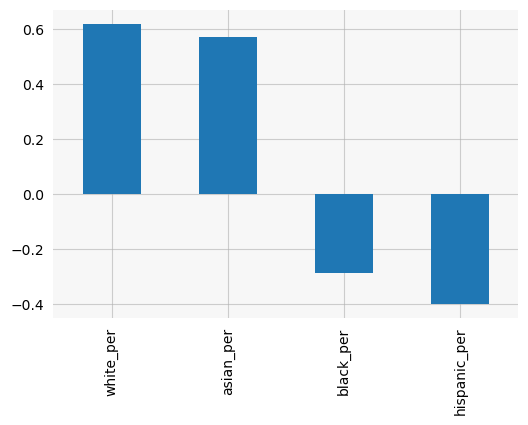

In [41]:
race_fields = ["white_per", "asian_per", "black_per", "hispanic_per"]
correlations['sat_score'][race_fields].plot.bar(figsize=(6, 4), zorder=2)
plt.tick_params(bottom=False, left=False)
plt.gca().set_facecolor('#f7f7f7')
plt.grid(alpha=0.6)
for i in ['right', 'left', 'bottom', 'top']:
    plt.gca().spines[i].set_visible(False) 
plt.show()

It looks like a higher percentage of white or asian students at a school correlates positively with sat score, whereas a higher percentage of black or hispanic students correlates negatively with sat score. This may be due to a lack of funding for schools in certain areas, which are more likely to have a higher percentage of black or hispanic students.

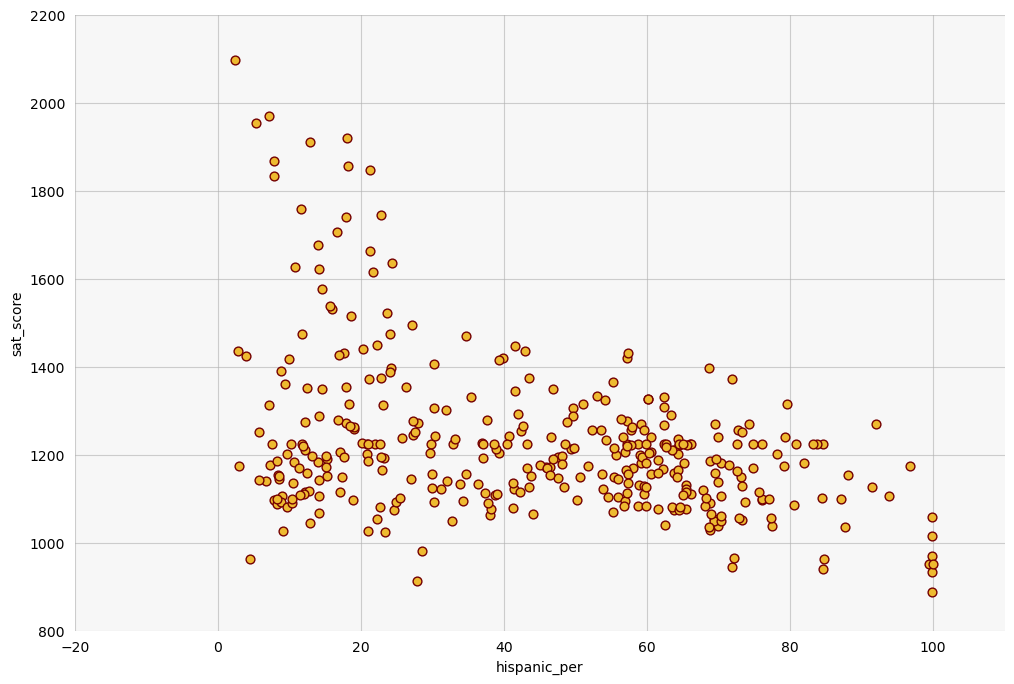

In [42]:
combined.plot.scatter('hispanic_per', 'sat_score', color='#eeba30',s=40,  figsize=(12,8), zorder=2, edgecolors='#740001')
plt.grid(alpha=0.6, zorder=1)
plt.xlim(-20, 110)
plt.ylim(800, 2200)
for i in ['right', 'left', 'bottom', 'top']:
    plt.gca().spines[i].set_visible(False) 
plt.tick_params(bottom=False, left=False)
plt.gca().set_facecolor('#f7f7f7')
plt.show()

In [43]:
combined[combined["hispanic_per"] > 95]["SCHOOL NAME"]

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The schools listed above appear to primarily be geared towards recent immigrants to the US. These schools have a lot of students who are learning English, which would explain the lower SAT scores.

In [44]:
combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]["SCHOOL NAME"]

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Many of the schools above appear to be specialized science and technology schools that receive extra funding, and only admit students who pass an entrance exam. This doesn't explain the low hispanic_per, but it does explain why their students tend to do better on the SAT -- they are students from all over New York City who did well on a standardized test.

## Gender Differences In SAT Scores

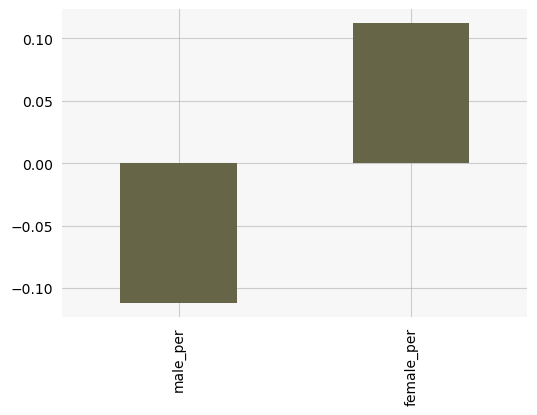

In [45]:
gender_fields = ["male_per", "female_per"]
correlations['sat_score'][gender_fields].plot.bar(figsize=(6, 4), color='#666547', zorder=2)
plt.tick_params(bottom=False, left=False)
plt.gca().set_facecolor('#f7f7f7')
plt.grid(alpha=0.6)
for i in ['right', 'left', 'bottom', 'top']:
    plt.gca().spines[i].set_visible(False) 
plt.show()

In the plot above, we can see that a high percentage of females at a school positively correlates with SAT score, whereas a high percentage of males at a school negatively correlates with SAT score. Neither correlation is extremely strong.

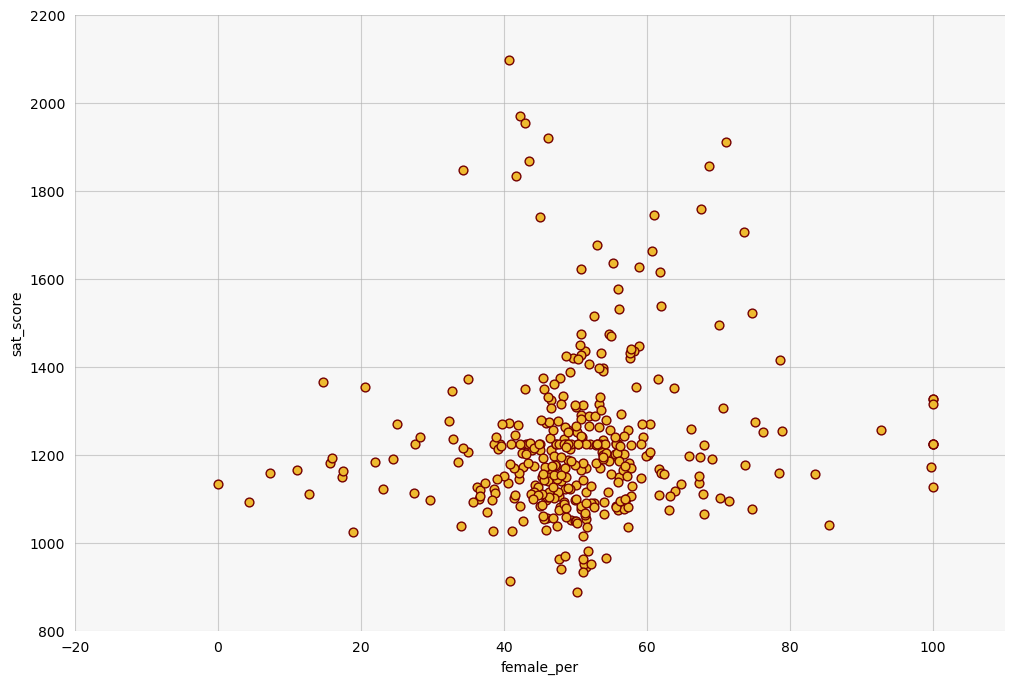

In [46]:
combined.plot.scatter('female_per', 'sat_score', color='#eeba30',s=40,  figsize=(12,8), zorder=2, edgecolors='#740001')
plt.grid(alpha=0.6, zorder=1)
plt.xlim(-20, 110)
plt.ylim(800, 2200)
for i in ['right', 'left', 'bottom', 'top']:
    plt.gca().spines[i].set_visible(False) 
plt.tick_params(bottom=False, left=False)
plt.gca().set_facecolor('#f7f7f7')
plt.show()

Based on the scatterplot, there doesn't seem to be any real correlation between sat_score and female_per. However, there is a cluster of schools with a high percentage of females (40 to 80), and high SAT scores.

In [47]:
combined[(combined["female_per"] > 40) & (combined["sat_score"] > 1800)]["SCHOOL NAME"]

5                         BARD HIGH SCHOOL EARLY COLLEGE
37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
155    HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
302                          TOWNSEND HARRIS HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

These schools appears to be very selective liberal arts schools that have high academic standards.

## AP Exam Scores Vs SAT Scores
In the US, the Advanced Placement, or AP, exams, are exams that high schoolers take in order to gain college credit. AP exams can be taken in many different subjects, and passing the AP exam means that colleges may grant you credits.

It makes sense that the number of students who took the AP exam in a school and SAT scores would be highly correlated, and let's dig into the relationship. Since total_enrollment is highly correlated with sat_score, we don't want to bias our results, so we'll instead look at the percentage of students in each school who took at least one AP exam.

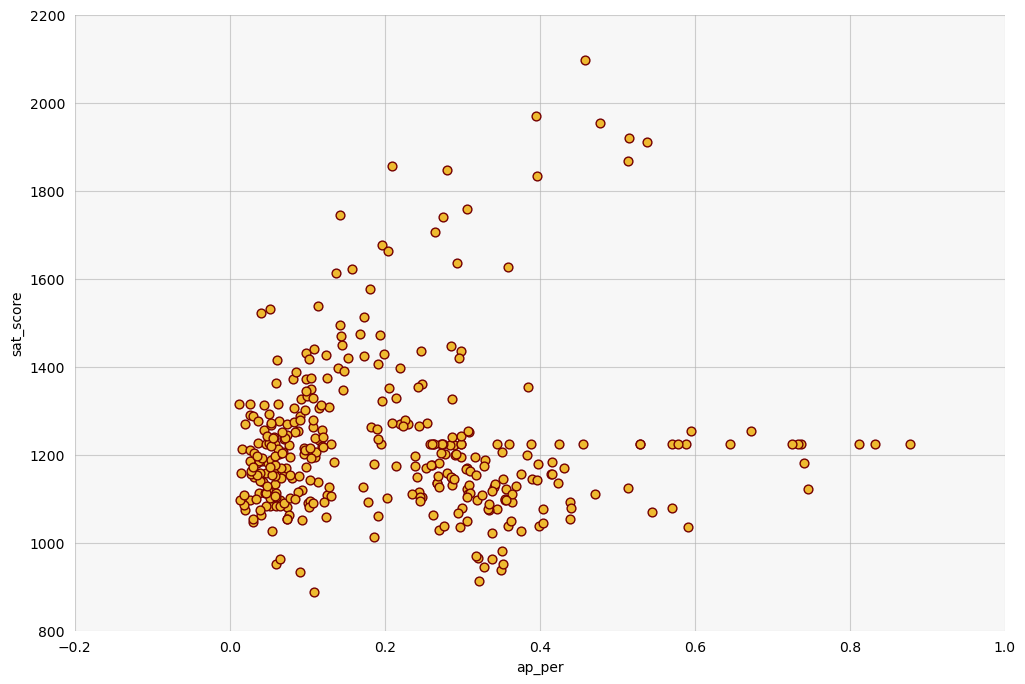

In [49]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]
combined.plot.scatter('ap_per', 'sat_score', color='#eeba30',s=40,  figsize=(12,8), zorder=2, edgecolors='#740001')
plt.grid(alpha=0.6, zorder=1)
plt.xlim(-0.2, 1)
plt.ylim(800, 2200)
for i in ['right', 'left', 'bottom', 'top']:
    plt.gca().spines[i].set_visible(False) 
plt.tick_params(bottom=False, left=False)
plt.gca().set_facecolor('#f7f7f7')
plt.show()

It looks like there is a relationship between the percentage of students in a school who take the AP exam, and their average SAT scores. It's not an extremely strong correlation, though.

## Ideas For Further Exploration
We've done quite a bit of investigation into demographics and SAT scores in this guided project. There's still quite a bit of analysis left to do, however. Here are some potential next steps:

- Looking at class size and SAT scores.
- Figuring out the best area to live in based on school performance.
- If we combine this with a property values dataset, we could find the cheapest place where there are good school.
- Looking into the differences between parent, teacher, and student responses to surveys.
- Assigning a score to schools based on sat_score and other attributes.